In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#######################################################################
########################### LOAD LIBRARIES ##############################
########################################################################

In [2]:
import re
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns

import nltk 
nltk.download('wordnet') 
nltk.download('omw-1.4') 
from nltk.tokenize import sent_tokenize 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 


# Clustering packages:
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meganpete/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/meganpete/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
########################################################################
########################### PREPROCESSING ##############################
########################################################################

In [3]:
## Tokenize + clean text, convert to dataframe

# Load data
with open("/Users/meganpete/Documents/Masters/Term 2/Machine Learning/Exam/text/data_train.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Split the text into separate abstracts
abstracts = re.split(r"[\n\s]*###\d+[\n\s]*", text)[1:]

# Tokenize and clean each sentence, and extract the label
labeled_sentences = []
tokens = []
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for abstract in abstracts:
    label_sentences = re.findall(r"(\b\w+\b)\s+(.+)", abstract)
    for label, sentence in label_sentences:
        sentence = re.sub(r'[^a-zA-Z]+',' ', sentence).strip() # Remove non alphabetic
        word_tokens = word_tokenize(sentence) # Tokenize
        cleaned_word_tokens = []
        for word in word_tokens:
            if word.lower() not in stop_words:
                word = lemmatizer.lemmatize(word) # Stem words
                cleaned_word_tokens.append(word.lower())
        cleaned_word_tokens = ' '.join(cleaned_word_tokens) # Convert to one sentence
        tokens.append(cleaned_word_tokens)
        labeled_sentences.append((label, cleaned_word_tokens)) # Add the labeled sentence to the list
        


In [4]:
# Convert to dataframe 
df = pd.DataFrame(labeled_sentences, columns = ['label','sentence'])

## Change this later -- making df smaller so that computations quicker
df = df.head(100000) ## CHANGE 
df


,label,sentence
0,OBJECTIVE,investigate efficacy week daily low dose oral ...
1,METHODS,total patient primary knee oa randomized recei...
2,METHODS,outcome measure included pain reduction improv...
3,METHODS,pain assessed using visual analog pain scale mm
4,METHODS,secondary outcome measure included western ont...
...,...,...
99995,METHODS,neodymium yag nd yag capsulotomy rate timing s...
99996,METHODS,survival analysis used compare nd yag rate
99997,METHODS,retroillumination image taken evaluate pco
99998,RESULTS,year significant difference fraction severity ...


In [5]:
## Create bag of words model 
corpus = list(df['sentence'])
vectorizer = TfidfVectorizer(max_features = 1000)
#Can change max features ****
X = vectorizer.fit_transform(corpus).toarray() 
y = df['label'].values
# Split into train and test 
# X_train_s, X_test_s , y_train_s, y_test_s = train_test_split(X, y , test_size = 0.20, random_state=101)

In [ ]:
########################################################################
####################### HYPERPARAMETER TUNING ##########################
########################################################################

In [ ]:
## KMEANS
# Define a range of number of clusters to test
k_range = [3,5,7,9]

# Initialize empty lists to store the SSE and silhouette scores
sse = []
silhouette_scores = []    

# Fit KMeans for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))



In [ ]:
silhouette_scores

In [ ]:
# Plot the elbow curve
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Plot the silhouette scores
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [ ]:
# Find the optimal number of clusters based on the highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is {optimal_k}")


In [ ]:
########################################################################
###################### BEST CLUSTERS ANALYSIS ##########################
########################################################################

In [ ]:
# K-means best k

k=5 

# Cluster the transformed data using K-means
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)



In [ ]:
ari = adjusted_rand_score(df['label'], y_pred)
print(f"Adjusted Rand index: {ari}")

In [ ]:
# Add cluster labels to dataframe
df['cluster'] = kmeans.labels_

# Compute label distribution within each cluster
label_dist = pd.crosstab(df['cluster'], df['label'], normalise='index')

import seaborn as sns
import matplotlib.pyplot as plt

# Add cluster labels to dataframe
df['cluster'] = kmeans.labels_

# Compute label distribution within each cluster
label_dist = pd.crosstab(df['cluster'], df['label'], normalise='index')

# Create heatmap
sns.heatmap(label_dist, cmap='YlGnBu')
plt.title('Label Distribution within Clusters')
plt.xlabel('Label')
plt.ylabel('Cluster')
plt.show()


In [ ]:
# K-means best k T-SNE plot

tsne = TSNE(n_components=2, perplexity=80, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the transformed data with different colors for each cluster
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_kmeans)
plt.title(f"t-SNE visualization with K-means clustering for k={k}")
plt.show()


In [ ]:
# PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# plot the first two principal components, colored by cluster label
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [170]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

# Define parameter grid
params = {'n_components': [2, 10, 50],
         'covariance_type': ['full', 'tied', 'diag', 'spherical']}

# Create GMM object
gmm = GaussianMixture(random_state=42)

# Create GridSearchCV object
grid = GridSearchCV(gmm, params, cv=5)

# Fit GridSearchCV object to training data
grid.fit(X)

# Get best model
best_gmm = grid.best_estimator_


The best model is {best_gmm}


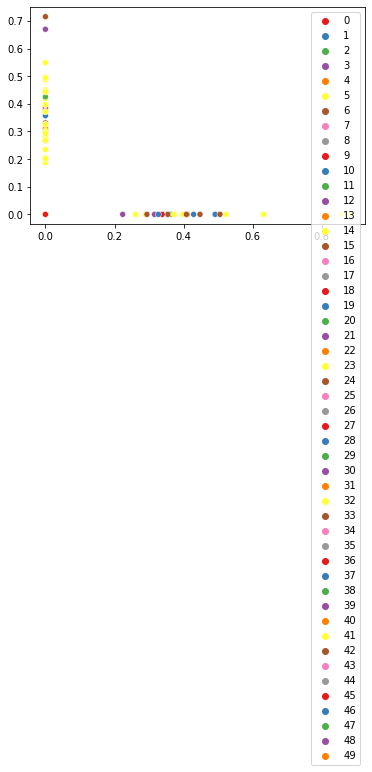

In [178]:
# Fit GMM to data
gmm = GaussianMixture(random_state=42, n_components = 50, covariance_type = 'spherical')
gmm.fit(X)
labels_gmm = gmm.predict(X)

# Plot clusters
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='Set1')
plt.show()


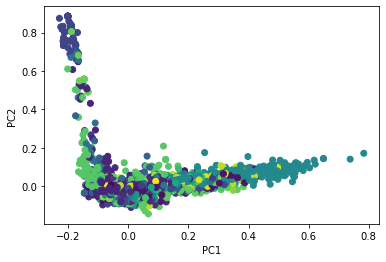

In [179]:
# PCA GMM

# Reduce dimensions with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot results
import matplotlib.pyplot as plt
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_gmm)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
